# 04-1 트랜스포머 인코더 모델 이해하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 어텐션 메커니즘

### 셀프 어텐션

In [1]:
import keras
from keras import layers

def self_attention(inputs, att_dim):
    # (n_batch, n_token, embed_dim) --> (n_batch, n_token, att_dim)
    query = layers.Dense(att_dim)(inputs)
    key = layers.Dense(att_dim)(inputs)
    value = layers.Dense(att_dim)(inputs)
    # score: (n_batch, n_token, n_token)
    key_t = keras.ops.transpose(k, axes=(0, 2, 1))
    query_key_dot = keras.ops.matmul(query, key_t) / keras.ops.sqrt(att_dim)
    score = keras.activations.softmax(query_key_dot)
    # (n_batch, n_token, att_dim)
    return keras.ops.matmul(score, value)

### 멀티 헤드 어텐션

In [2]:
inputs = keras.Input(shape=(10, 20))
x = layers.MultiHeadAttention(num_heads=4, key_dim=5)(query=inputs,
                                                      value=inputs)
model = keras.Model(inputs, x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 20)    │      1,680 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,680 (6.56 KB)

 Trainable params: 1,680 (6.56 KB)

 Non-trainable params: 0 (0.00 B)

## 위치 인코딩과 층 정규화

### 위치 인코딩

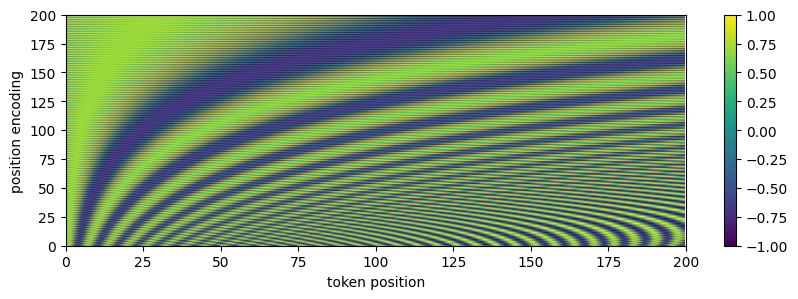

In [3]:
import numpy as np
import matplotlib.pyplot as plt

d = 500
n_token = 200
pos_encoding = np.zeros((d, n_token))
for p in range(n_token):
    for i in range(0, d, 2):
        pos_encoding[i, p] = np.sin(p/10000**(i/d))
        pos_encoding[i+1, p] = np.cos(p/10000**(i/d))
plt.figure(figsize=(10, 3))
plt.imshow(pos_encoding, interpolation="quadric", aspect="auto")
plt.axis([0, n_token, 0, 200])
plt.xlabel('token position')
plt.ylabel('position encoding')
plt.colorbar()
plt.show()

In [4]:
pos_encoding.shape

(500, 200)

In [5]:
vocab_size = 10000
embed_dim = 768
max_seq_len = 512

inputs = keras.Input(shape=(None,))
token_embedding = layers.Embedding(vocab_size, embed_dim)(inputs)
token_pos = keras.ops.arange(n_token)
pos_embedding = layers.Embedding(max_seq_len, embed_dim)(token_pos)
encoder_inputs = token_embedding + pos_embedding

### 층 정규화

In [6]:
data = np.arange(12, dtype="float32").reshape(2, 2, 3)
print(data)

[[[ 0.  1.  2.]
  [ 3.  4.  5.]]

 [[ 6.  7.  8.]
  [ 9. 10. 11.]]]


In [7]:
batchnorm = layers.BatchNormalization()
print(batchnorm(data, training=True).numpy())

[[[-1.3415811  -1.3415811  -1.3415811 ]
  [-0.44719368 -0.44719374 -0.44719374]]

 [[ 0.44719374  0.44719374  0.44719374]
  [ 1.3415811   1.341581    1.3415812 ]]]


In [8]:
temp = np.array([0, 3, 6, 9])
(temp - np.mean(temp)) / (np.sqrt(np.var(temp) + 1e-3))

array([-1.34158116, -0.44719372,  0.44719372,  1.34158116])

In [9]:
layernorm = layers.LayerNormalization()
print(layernorm(data).numpy())

[[[-1.2238274  0.         1.2238274]
  [-1.2238274  0.         1.2238274]]

 [[-1.2238274  0.         1.2238274]
  [-1.2238274  0.         1.2238274]]]


In [10]:
temp = np.array([0, 1, 2])
(temp - np.mean(temp)) / (np.sqrt(np.var(temp) + 1e-3))

array([-1.22382734,  0.        ,  1.22382734])

## 트랜스포머 인코더 모델 만들기

In [11]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = hidden_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(hidden_dim * 4, activation=activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x